# **Dog Breed Classification using CNNs**

---

## **1. Business Objective**

Image classification is the process of taking an input (like a picture) and outputting a class or a probability that the input is a particular class.

The World Canine Organization (FCI) is currently listing more than 300 officially recognised dog breeds. 

The aspiring and astonishing field of Deep Learning and artificial neural networks provides powerful concepts and methods that will help us in this sort of classification tasks. In this project we will develop ideas for a dog identification app using CNNs.

The software is intended to accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog’s breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling.


## **2. Data Collection**

The data was provided by Udacity.

Dog Dataset Link: https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip 

Humans Link: https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip


The image data comprises 8351 dog images and 133 separate dog breed names.
and 13233 images from the labeled human faces in the wild dataset.

In [ ]:
# Connecting to Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)
plt.style.use('seaborn')

In [ ]:
# Importing the ML/DL libraries
import cv2                

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

from sklearn.datasets import load_files       

from tensorflow.keras.callbacks import ModelCheckpoint  
from datetime import datetime

from tensorflow.keras.applications import ResNet50, InceptionV3, resnet50

In [ ]:
# Importing few helper libraries

import sys 
import os
import random
import shutil
import zipfile
from glob import glob
from datetime import datetime
from tqdm import tqdm

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## **3. Data Preparation/Preprocessing**

We will start with loading and familiarizing with the dataset so that we can prepare the data for Machine Learning (ML) modelling.

In [ ]:
# Loading the dataset

#!cp $(DRIVE_ZIP_DIR/dogImages.zip" /tmp
DRIVE_ZIP_DIR = "/content/drive/MyDrive/Colab Datasets/Dog Breed Classification"

dog_source_file_path = os.path.join(DRIVE_ZIP_DIR, "dogImages.zip")
human_source_file_path = os.path.join(DRIVE_ZIP_DIR, "lfw.zip")

dog_dest_file_path = os.path.join("/tmp", "dogImages.zip")
human_dest_file_path = os.path.join("/tmp", "lfw.zip")

print("Copying from drive to temp folder...")
shutil.copyfile(dog_source_file_path, dog_dest_file_path)
shutil.copyfile(human_source_file_path, human_dest_file_path)

print("Extracting all images...")
dog_zip_ref = zipfile.ZipFile(dog_dest_file_path, 'r')
dog_zip_ref.extractall('/tmp')
dog_zip_ref.close()

human_zip_ref = zipfile.ZipFile(human_dest_file_path, 'r')
human_zip_ref.extractall('/tmp')
human_zip_ref.close()

print("Done..")

Copying from drive to temp folder...
Extracting all images...
Done..


In [ ]:
# All images have been un-zipped under this folder.
# There are three sub-folders for training, validation and testing image sets

images_root = "/tmp/dogImages"

train_root = os.path.join(images_root, "train")
eval_root = os.path.join(images_root, "valid")
test_root = os.path.join(images_root, "test")

In [ ]:
# Define function to load train, test, and validation datasets

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data["filenames"])
    dog_targets = np_utils.to_categorical(np.array(data["target"]), len(np.unique(np.array(data["target"]))))
    return dog_files, dog_targets

In [ ]:
# Load train, test, and validation datasets

train_files, train_targets = load_dataset(train_root)
valid_files, valid_targets = load_dataset(eval_root)
test_files, test_targets = load_dataset(test_root)

In [ ]:
# Load list of dog breed names from path names

dog_names = [item[25:-1] for item in sorted(glob(train_root + "/*/"))]

In [ ]:
# Checking statistics about the dataset

print('There are %d total dog breeds.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))

print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog breeds.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [ ]:
# Load filenames in shuffled human dataset

human_root = os.path.join("/tmp", "lfw")
human_files = np.array(glob(human_root + "/*/*"))
random.shuffle(human_files)

print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---

We will use OpenCV's implementation of "Haar feature-based cascade classifiers" to detect human faces in images. OpenCV provides many pre-trained face detectors.

Number of faces detected: 1
Number of faces detected: 1
Number of faces detected: 1
Number of faces detected: 1
Number of faces detected: 1


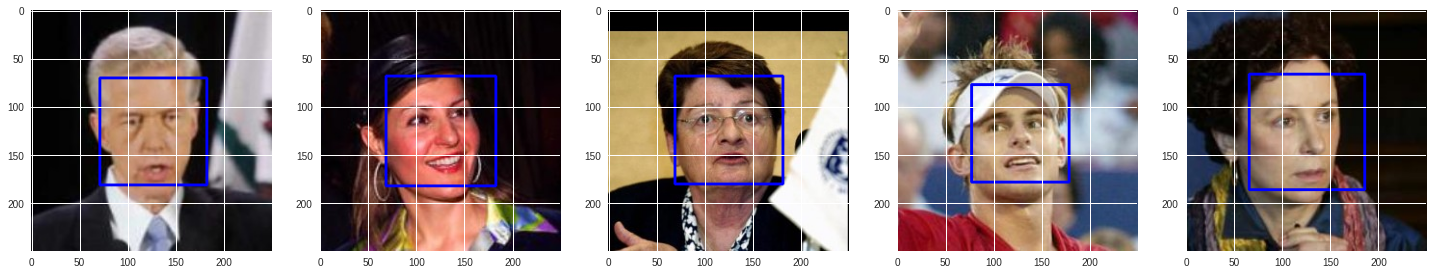

In [ ]:
# Extract pre-trained face detector

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + '/haarcascade_frontalface_alt.xml')
fig, ax = plt.subplots(1, 5, figsize=(25,15))

for i in range(5):
    # Load color (BGR) image
    img_index = random.randint(0, len(human_files)-1)
    img = cv2.imread(human_files[img_index])
    
    # Convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find faces in image
    faces = face_cascade.detectMultiScale(gray)
    print('Number of faces detected:', len(faces))

    # Get bounding box for each detected face
    for (x, y, w, h) in faces:
        # Add bounding box to color image
        cv2.rectangle(img, (x,y), (x+w,y+h), (255, 0, 0), 2)

    # Convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image, along with bounding box
    plt.subplot(1, 5, i+1)
    plt.imshow(cv_rgb)

Observations:

Before using any of the face detectors, it is standard procedure to convert the images to grayscale. The "detectMultiScale" function executes the classifier stored in face_cascade and takes the grayscale image as a parameter.

In the above code, "faces" is a numpy array of detected faces, where each row corresponds to a detected face. Each detected face is a 1D array with four entries that specifies the bounding box of the detected face. The first two entries in the array (extracted in the above code as x and y) specify the horizontal and vertical positions of the top left corner of the bounding box. The last two entries in the array (extracted here as w and h) specify the width and height of the box.

In [ ]:
# Function to detect face and return "True" if detected in the given image

def Face_Detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [ ]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Calculate percentage of detected human faces in human_files
results = []
for file in (human_files_short):
    results.append(Face_Detector(file))
np_results_humans = np.array(results)
print("Detected faces in Human files: {}".format(np.sum(np_results_humans)))

# calculate percentage of detected human faces in dog_files
results = []
for file in (dog_files_short):
    results.append(Face_Detector(file))
np_results_dogs = np.array(results)
print("Detected Faces in Dog files: {}".format(np.sum(np_results_dogs)))

Detected faces in Human files: 99
Detected Faces in Dog files: 12


Observations:

We are trying to identify faces detected in the human files and the dog files by selecting 100 images each at random, to check whether accuracy of the algorithms.

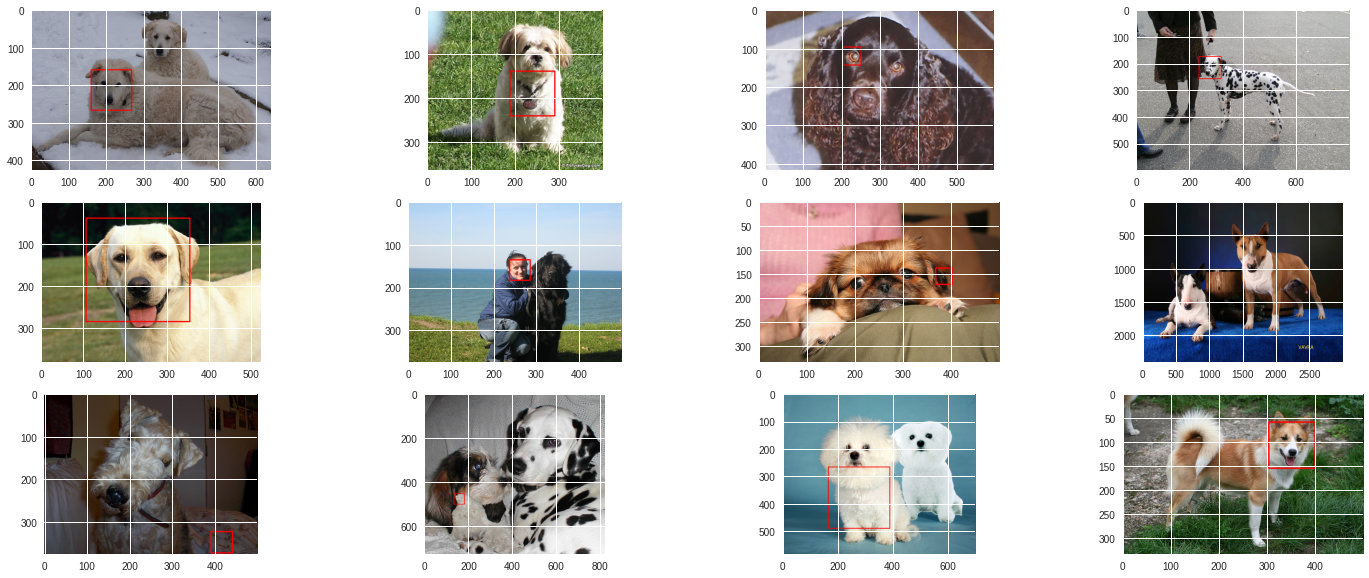

In [ ]:
# Show false positives dogs

fig, ax = plt.subplots(3, 4, figsize=(25, 10))
false_positives_idx = np.where(np_results_dogs)[0]

for i, idx in enumerate(false_positives_idx):    
    # Load color (BGR) image  
    img = cv2.imread(dog_files_short[idx])
    # Convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find faces in image
    faces = face_cascade.detectMultiScale(gray)
    # Get bounding box for each detected face
    color = (0, 0, 255) 
    for (x, y, w, h) in faces:
        # Add bounding box to color image
        cv2.rectangle(img, (x,y), (x+w,y+h), color, 2)

    # Convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # display the image, along with bounding box
    plt.subplot(3, 4, i+1)
    plt.imshow(cv_rgb)

Observations:

There were 12 images of dogs where the face detectors detected face which can be termed false positives.

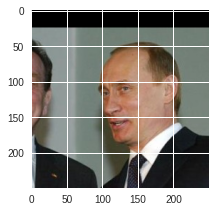

In [ ]:
# Show false negatives humans

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
false_negatives_idx = np.where(np_results_humans == False)[0]

for i, idx in enumerate(false_negatives_idx):
    # Load color (BGR) image
    img = cv2.imread(human_files_short[idx])
    # Convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find faces in image
    faces = face_cascade.detectMultiScale(gray)
    # Get bounding box for each detected face
    color = (0, 0, 255) 
    for (x, y, w, h) in faces:
        # Add bounding box to color image
        cv2.rectangle(img, (x,y), (x+w,y+h), color, 2)
    # Convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Display the image, along with bounding box
    plt.subplot(1, 2, i+1)
    plt.imshow(cv_rgb)

Observations:

There is one image where face was not detected by the algorithm. The reason could possibly be due to the face is slightly turned so the complete face is not visible.


## **4. Model Building**

---


### **4.1 Building ResNet50 Pre-Trained Model**

In this section, we use a pre-trained ResNet-50 model to detect dogs in images.

Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [ ]:
# Define ResNet50 model

ResNet50_model = ResNet50(weights='imagenet')
print("Done..")

Done..


When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape (nb_samples, rows, columns,channels)

where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.


In [2]:
# Loading the image using path and converting it into 4D Tensors

def ConvertImageTo4DTensor(img_path):
    # Load RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # Convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def CreateImageTensors(img_paths):
    list_of_tensors = [ConvertImageTo4DTensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions. 

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this dictionary.



In [ ]:
# Using the ResNet50's preprocessing to pre-process the 4D Image Tensor and predict the class label

def ResNet50_Predict_Labels(img_path):
    # Returns prediction vector for image located at img_path
    img = resnet50.preprocess_input(CreateImageTensors(img_path))
    return np.argmax(ResNet50_model.predict(img))

While looking at the dictionary, we noticed that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from 'Chihuahua' to 'Mexican hairless'.

Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the ResNet50_predict_labels function above returns a value between 151 and 268 (inclusive).


In [ ]:
# Returns "True" if a dog is detected in the image stored at img_path

def Dog_Detector(img_path):
    prediction = ResNet50_Predict_Labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [ ]:
### Test the performance of the Dog_Detector function on the images in human_files_short and dog_files_short.
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Calculate percentage of detected human faces in human_files
results = []
for file in (human_files_short):
    results.append(Dog_Detector([file]))
np_human_results = np.array(results)
print("Percentage of detected dogs in human files: {} %".format(np.sum(np_human_results)))

# Calculate percentage of detected human faces in dog_files
results = []
for file in (dog_files_short):
    results.append(Dog_Detector([file]))  
np_dog_results = np.array(results)
print("Percentage of detected dogs in dog files: {} %".format(np.sum(np_dog_results)))

Percentage of detected dogs in human files: 0 %
Percentage of detected dogs in dog files: 100 %


Observations:

Obviously, the classifier correctly detected dog content in each of the dog images. 

Let's now take a look on the human image, which was potentially misclassified:



In [ ]:
# Checking how many dog images were classified as human face

len(np.where(np_dog_results == False)[0])

0

Observations:

There are no dog images classified as human faces.

### **4.2 CNN From Scratch**

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. 

In this step, we will create a CNN that classifies dog breeds. 


In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# Pre-process the data for Keras
train_tensors = CreateImageTensors(train_files).astype('float32')/255
valid_tensors = CreateImageTensors(valid_files).astype('float32')/255
test_tensors = CreateImageTensors(test_files).astype('float32')/255

In [ ]:
### Defining the architecture.

model = Sequential()
model.add(Conv2D(16, kernel_size=2, activation='relu', padding='valid', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(Conv2D(32, kernel_size=2, activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(Conv2D(64, kernel_size=2, activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(Conv2D(128, kernel_size=2, activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(Conv2D(256, kernel_size=2, activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(units=133, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       3

In [ ]:
# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Training the model

startTime = datetime.now()
print("Training started..")

epochs = 30
checkpointer = ModelCheckpoint(filepath=DRIVE_ZIP_DIR + "/weights.best.from_scratch.hdf5", verbose=1, save_best_only=True)
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
                    train_tensors, train_targets, 
                    validation_data=(valid_tensors, valid_targets),
                    epochs=epochs, 
                    batch_size=20, 
                    callbacks=[checkpointer, tensorboard_callback], 
                    verbose=1
                    )

print("The training is complete after taking time of ", (datetime.now() - startTime))

Training started..
Epoch 1/30
 1/42 [..............................] - ETA: 0s - loss: 4.8924 - accuracy: 0.0000e+00WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
42/42 [==============================] - ETA: 0s - loss: 4.8951 - accuracy: 0.0024
Epoch 00001: val_loss improved from inf to 4.88752, saving model to /content/drive/MyDrive/Colab Datasets/Dog Breed Classification/weights.best.from_scratch.hdf5
42/42 [==============================] - 38s 914ms/step - loss: 4.8951 - accuracy: 0.0024 - val_loss: 4.8875 - val_accuracy: 0.0120
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 4.8882 - accuracy: 0.0084
Epoch 00002: val_loss improved from 4.88752 to 4.88081, saving model to /content/drive/MyDrive/Colab Datasets/Dog Breed Classification/

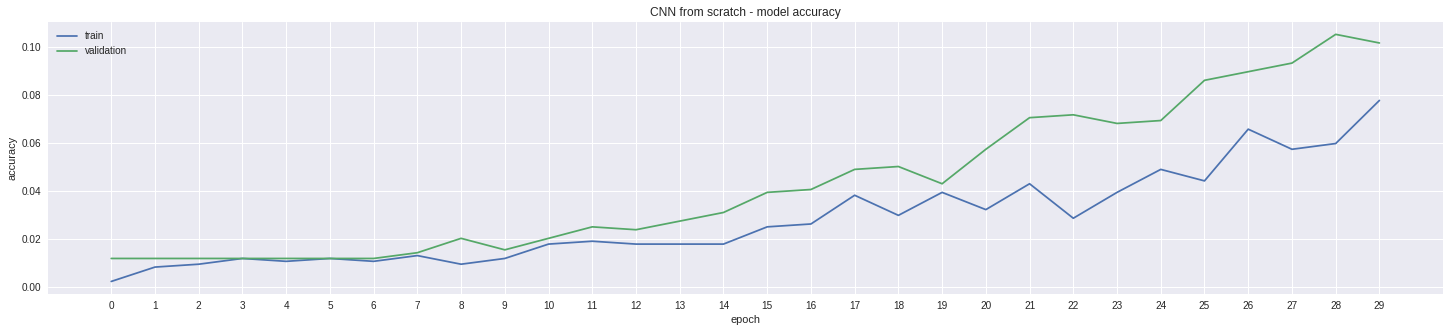

In [ ]:
# Visualizing the Training and Validation Accuracy

plt.style.use("seaborn")
figure, ax = plt.subplots(1, 1, figsize=(25, 5))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title("CNN from Scratch - Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc="upper left")
_ = plt.xticks(range(0, epochs))

In [ ]:
# Loading the trained model
model.load_weights(DRIVE_ZIP_DIR + "/weights.best.from_scratch.hdf5")

# Get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# Report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print("Test accuracy: %.4f%%" % test_accuracy)

Test accuracy: 10.1675%


Observations:

As evident, the Training, Validation and Testing accuracy remains to 7%, 10% and 10% respectively.

### **4.3 Transfer Learning using ResNet50 Model**

Let's use transfer learning from pre-trained ResNet50 architecture to build the Dog Breed Classification Model.

In [ ]:
# Loading the Pre-processed inputs

bottleneck_features = np.load(DRIVE_ZIP_DIR + "/DogResnet50Data.npz")
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [ ]:
# Defining the architecture on top of ResNet50 model

ResNet50_model_trained = Sequential()
ResNet50_model_trained.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
ResNet50_model_trained.add(Dropout(0.5))
ResNet50_model_trained.add(BatchNormalization())
ResNet50_model_trained.add(Dense(133, activation='softmax'))

ResNet50_model_trained.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 280,709
Trainable params: 276,613
Non-trainable params: 4,096
_________________________________________________________________


In [ ]:
### Compile the model

ResNet50_model_trained.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Training the Model

epochs = 30
checkpointer = ModelCheckpoint(filepath=DRIVE_ZIP_DIR+'/weights.best.ResNet50.hdf5', verbose=1, save_best_only=True)
ResNet50_history = ResNet50_model_trained.fit(
                                              train_Resnet50, 
                                              train_targets, 
                                              validation_data=(valid_Resnet50, valid_targets),
                                              epochs=epochs, 
                                              batch_size=20, 
                                              callbacks=[checkpointer], 
                                              verbose=1
                                              )


Epoch 1/30
324/334 [============================>.] - ETA: 0s - loss: 2.4316 - accuracy: 0.4264
Epoch 00001: val_loss improved from inf to 0.91260, saving model to /content/drive/MyDrive/Colab Datasets/Dog Breed Classification/weights.best.ResNet50.hdf5
334/334 [==============================] - 2s 5ms/step - loss: 2.3958 - accuracy: 0.4329 - val_loss: 0.9126 - val_accuracy: 0.7401
Epoch 2/30
325/334 [============================>.] - ETA: 0s - loss: 0.8201 - accuracy: 0.7595
Epoch 00002: val_loss improved from 0.91260 to 0.73588, saving model to /content/drive/MyDrive/Colab Datasets/Dog Breed Classification/weights.best.ResNet50.hdf5
334/334 [==============================] - 1s 4ms/step - loss: 0.8161 - accuracy: 0.7596 - val_loss: 0.7359 - val_accuracy: 0.7892
Epoch 3/30
322/334 [===========================>..] - ETA: 0s - loss: 0.5585 - accuracy: 0.8295
Epoch 00003: val_loss improved from 0.73588 to 0.69975, saving model to /content/drive/MyDrive/Colab Datasets/Dog Breed Classifica

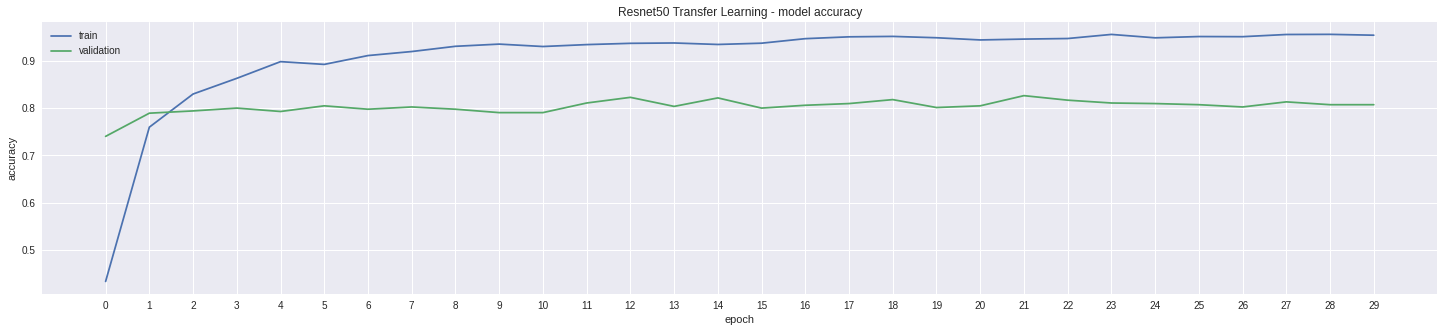

In [ ]:
# Visualizing the Train and Validaton Accuracy

plt.style.use("seaborn")
plt.figure(figsize=(25, 5))

plt.plot(ResNet50_history.history["accuracy"])
plt.plot(ResNet50_history.history["Val_accuracy"])

plt.title("Resnet50 Transfer Learning - Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
_ = plt.xticks(range(0, epochs))

In [ ]:
# Get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(ResNet50_model_trained.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# Report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.6986%


Observations:

We have build a very good model with 95% Training accuracy, 80%+ for Validation and Testing accuracy. 

### **4.4 Transfer Learning using InceptionV3 Model**

We will try the inception model as well to see if we can better the accuracy acheived by ResNet50 Model.

In [ ]:
# Obtain bottleneck features from a pre-trained Inception CNN.

bottleneck_features = np.load(DRIVE_ZIP_DIR + "/DogInceptionV3Data.npz")
train_InceptionV3 = bottleneck_features["train"]
valid_InceptionV3 = bottleneck_features["valid"]
test_InceptionV3 = bottleneck_features["test"]

In [ ]:
# Definng the architecture on top of InceptionV3 architecture

InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape= train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dropout(0.5))
InceptionV3_model.add(BatchNormalization())
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 280,709
Trainable params: 276,613
Non-trainable params: 4,096
_________________________________________________________________


In [ ]:
### Compile the model

InceptionV3_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Training the Model

epochs = 100
checkpointer = ModelCheckpoint(filepath=DRIVE_ZIP_DIR+'/weights.best.InceptionV3.hdf5', verbose=1, save_best_only=True)

InceptionV3_history = InceptionV3_model.fit(
                                            train_InceptionV3, 
                                            train_targets, 
                                            validation_data=(valid_InceptionV3, valid_targets),
                                            epochs=epochs, 
                                            batch_size=20, 
                                            callbacks=[checkpointer], 
                                            verbose=1
                                            )

Epoch 1/100
331/334 [============================>.] - ETA: 0s - loss: 1.5798 - accuracy: 0.6145
Epoch 00001: val_loss improved from inf to 0.52640, saving model to /content/drive/MyDrive/Colab Datasets/Dog Breed Classification/weights.best.InceptionV3.hdf5
334/334 [==============================] - 2s 6ms/step - loss: 1.5719 - accuracy: 0.6163 - val_loss: 0.5264 - val_accuracy: 0.8443
Epoch 2/100
332/334 [============================>.] - ETA: 0s - loss: 0.5942 - accuracy: 0.8208
Epoch 00002: val_loss did not improve from 0.52640
334/334 [==============================] - 2s 6ms/step - loss: 0.5953 - accuracy: 0.8205 - val_loss: 0.5513 - val_accuracy: 0.8323
Epoch 3/100
329/334 [============================>.] - ETA: 0s - loss: 0.4626 - accuracy: 0.8549
Epoch 00003: val_loss did not improve from 0.52640
334/334 [==============================] - 2s 5ms/step - loss: 0.4614 - accuracy: 0.8552 - val_loss: 0.5534 - val_accuracy: 0.8467
Epoch 4/100
329/334 [============================>.] 

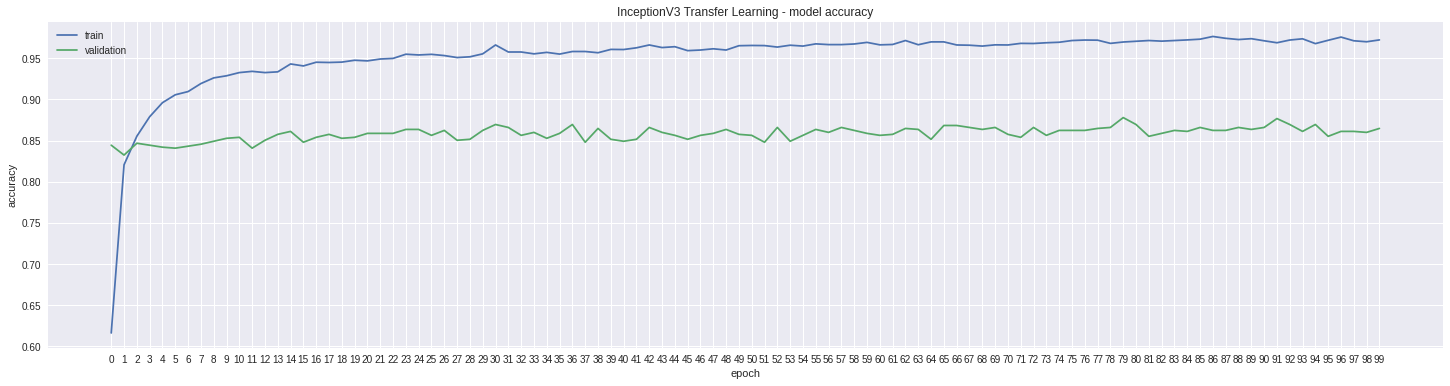

In [ ]:
# Visualizing the Train and Validation loss

plt.style.use("seaborn")
plt.figure(figsize=(25, 6))

plt.plot(InceptionV3_history.history["accuracy"])
plt.plot(InceptionV3_history.history["val_accuracy"])

plt.title("InceptionV3 Transfer Learning - Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
_ = plt.xticks(range(0, epochs))

In [ ]:
# Get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# Report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print("Test accuracy: %.4f%%" % test_accuracy)

Test accuracy: 83.2536%


Observations:

We build a better model for sure as it is acheiving 97% Training Accuracy, 86% Validation Accuracy and 83% Training Accuracy.

### **4.5 Testing App**

Writing an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither. 

Then,
  - if a dog is detected in the image, return the predicted breed.
  - if a human is detected in the image, return the resembling dog breed.
  - if neither is detected in the image, provide output that indicates an error.



In [ ]:
# Extracting InceptionV3 preprocessed inputs from image tensors

def extract_InceptionV3(tensor):

	from keras.applications.inception_v3 import InceptionV3, preprocess_input

	return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [ ]:
# Predicting the dog breed

def InceptionV3_predict_breed(img_path):
    # Extract bottleneck features
    bottleneck_feature = extract_InceptionV3(ConvertImageTo4DTensor(img_path))
    # Obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # Return dog breed that is predicted by the model

    return dog_names[np.argmax(predicted_vector)]

In [ ]:
# Function to show 4 random images of a specific dog breed

def show_breed_images(str_breed):
   
    fig, ax = plt.subplots(1, 4, figsize=(16, 8))
    img_idx =  np.flatnonzero(np.core.defchararray.find(train_files,str_breed)!=-1)
    
    for i, idx in enumerate(np.random.choice(img_idx, 4)):
        plt.subplot(1, 4, i+1)
        img = cv2.imread(train_files[idx])
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)

In [ ]:
# Final algorithm:

def evaluate_image(img_path):

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Output image input
    plt.imshow(img)
    
    dog_breed = InceptionV3_predict_breed(img_path)
    hint_text = ", like the ones on the 4 images below the input picture."
    text = "Hmmm, I can't see any humans or dogs in this picture, but it reminds me a bit of a " + dog_breed + hint_text
    
    if (Dog_Detector([img_path])):
        text = "I'm pretty sure it's a dog. I think it could be a " + dog_breed + hint_text
    elif (Face_Detector(img_path)):
        text = "You're definitely human, but if you were a dog you could be a " + dog_breed + hint_text
    
    # Output text
    print(text)
    # Output 4 sample images of the recognized dog breed:
    show_breed_images(dog_breed)

In [ ]:
# Predicting Dog Breed using path for the image

def PredictDogBreed(test_image_path):
    evaluate_image(test_image_path)

I'm pretty sure it's a dog. I think it could be a German_shepherd_dog, like the ones on the 4 images below the input picture.


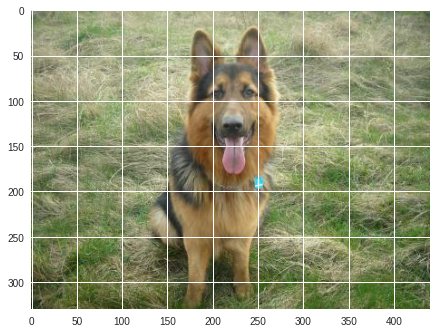

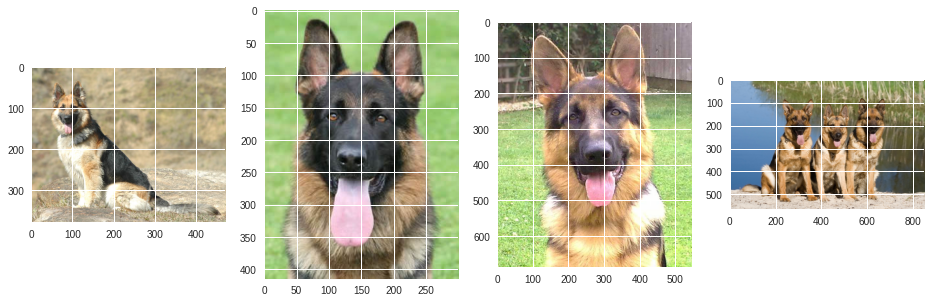

In [ ]:
PredictDogBreed(random.choice(test_files))

I'm pretty sure it's a dog. I think it could be a Bloodhound, like the ones on the 4 images below the input picture.


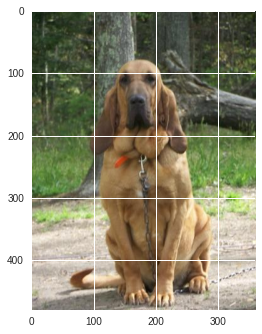

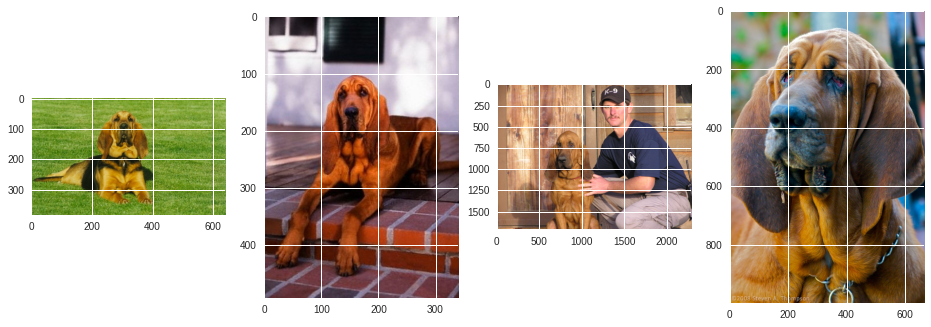

In [ ]:
PredictDogBreed(random.choice(test_files))

I'm pretty sure it's a dog. I think it could be a Chinese_crested, like the ones on the 4 images below the input picture.


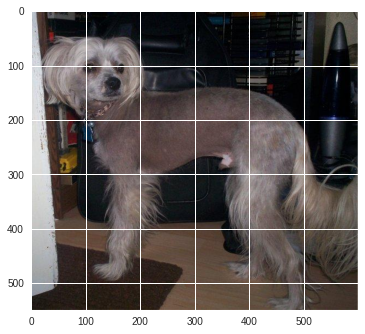

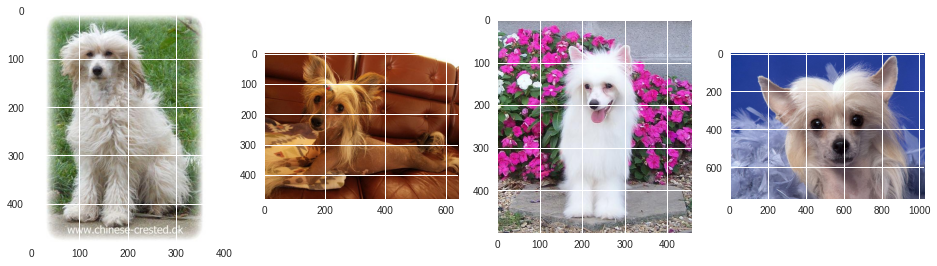

In [ ]:
PredictDogBreed(random.choice(test_files))

I'm pretty sure it's a dog. I think it could be a Bloodhound, like the ones on the 4 images below the input picture.


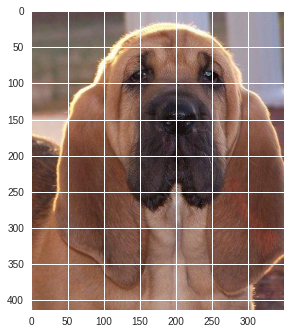

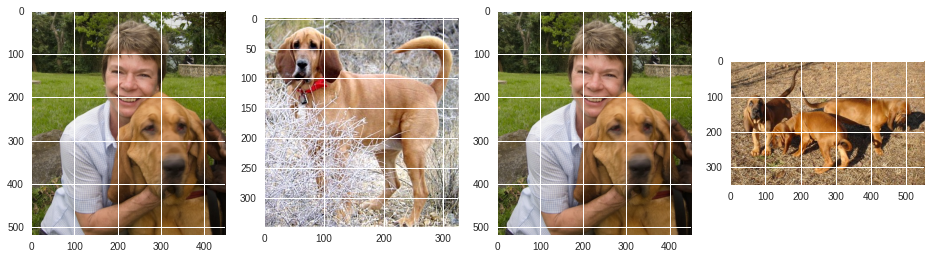

In [ ]:
PredictDogBreed(random.choice(test_files))

You're definitely human, but if you were a dog you could be a Finnish_spitz, like the ones on the 4 images below the input picture.


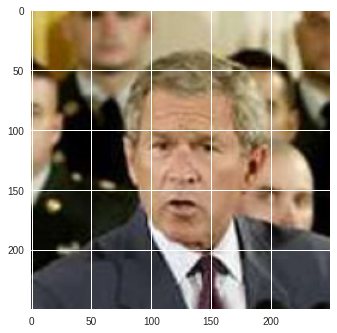

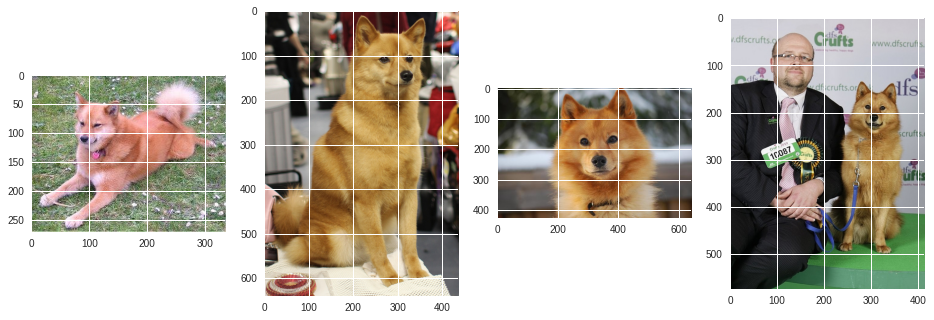

In [ ]:
PredictDogBreed(human_files[random.choice(range(0, len(human_files)))])

## **5. Conclusion**

In this project we developed several approaches for the development of an app for the identification of dog breeds, and we achieved our best results with the application of a transfer learning model. We achieved an accuracy of 83% in our tests using InceptionV3 Model. 

We also learned how to build convolution networks from scratch, which was a very educational undertaking, even though we soon realized that there are significantly more promising methods, particularly with the application of transfer learning.

However, we still see several options to further improve our algorithm in the future:
  1. We could gather more training data.
  2. We could employ data augmentation to prevent overfitting.
  3. We could add more layers to make our model more complex and hopefully more powerful.
  4. We could extend our training time and add more epochs to the training.

But all in all, the accuracy levels from our tests, along with the tests with specific sample images, suggest that we already have a serious model we could work with in a real app.